In [1]:
# Copyright 2019 Google LLC
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
This notebook evaluates guided mutation in combination with different selection techniques.

Requirements: 

-This notebook requires that tensorflow and numpy be installed within the 
Python environment you are running this script in. 

"""
import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append('..')
from utils.nas_utils import load_nasbench, run_xevolution, crossover, guided_mutation, random_combination
from utils.plotting import plot_all
from IPython.display import clear_output

nasb = load_nasbench()




No GPU.
Loading dataset from file... This may take a few minutes...
Loaded dataset in 551.1943080425262 seconds


In [ ]:
# here, we test out different selection methods
# our selection functions have to follow 
# def selection(parents) -> paired parents 

def random_selection(parents):
    """Selects n random parent pairs of a population."""
    paired_parents = []
    for _ in range(len(parents)):
        i1 = np.random.randint(len(parents))
        i2 = np.random.randint(len(parents))
        p1 = parents[i1]
        p2 = parents[i2]
        paired_parents.append((p1,p2)) 
    return paired_parents

def tournament_selection(population,  population_size=50, tournament_size=10):
    """Selects n parent pairs of a population with size n using tournament."""
    parents = []
    for _ in range(population_size):
        candidates = random_combination(population, tournament_size)
        p1 = sorted(candidates, key=lambda i: i[0])[-1]
        p2 = sorted(candidates, key=lambda i: i[0])[-2]
        parents.append((p1,p2))
    return parents

def greedy_selection(parents):
    """Selects greedy n parent pairs"""
    p_size = len(parents)
    population = np.asarray([p[0] for p in parents])

    summed_population = []
    for p1 in range(p_size):
        for p2 in range(p_size):
            if p1 < p2: # only upper triangle
                sum = population[p1] + population[p2]
            else:
                sum = 0
            summed_population.append(sum)

    samples = np.argsort(summed_population)[-p_size:]
    row_indices, col_indices = np.meshgrid(np.arange(p_size),np.arange(p_size))
    mapping = np.reshape(np.stack([col_indices,row_indices],axis=-1), [-1,2])
    pairings = mapping[samples]

    paired_parents = []
    for i in range(len(pairings)):
        p1 = parents[pairings[i,0]]
        p2 = parents[pairings[i,1]]
        paired_parents.append((p1,p2))

    return paired_parents



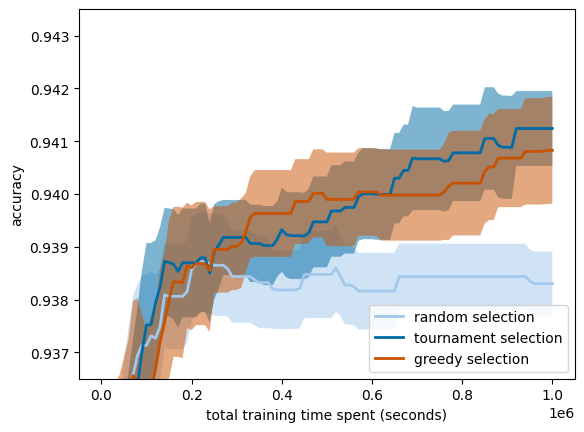

Running repeat 15


In [ ]:
# comparing different methods

s1 = lambda parents: random_selection(parents)
s2 = lambda parents: tournament_selection(parents, 50, 10)
s3 = lambda parents: greedy_selection(parents)


exp1 = {
    "data": 
    {
        "random selection" : [[],"Light Blue"],
        "tournament selection" : [[],"Dark Blue"],
        "greedy selection" : [[],"Red Orange"],
    },
    "config": 
    {
        "budget" : int(1e6),
        "limits" : (0.9365, 0.9435),
        "n" : 100,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, s1, crossover, guided_mutation, budget, 50)
    exp1["data"]["random selection"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, s2, crossover, guided_mutation, budget, 50)
    exp1["data"]["tournament selection"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, s3, crossover, guided_mutation, budget, 50)
    exp1["data"]["greedy selection"][0].append((times, best_valid, best_test))

    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()